In [4]:

import pylabnet.hardware.awg.zi_hdawg as zi_hdawg
from pylabnet.utils.logging.logger import LogClient


import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import time

from IPython.display import clear_output, display

import pyvisa
from pylabnet.utils.logging.logger import LogClient
from pylabnet.network.client_server import agilent_e4405B
import pylabnet.hardware.spectrum_analyzer.agilent_e4405B as sa_hardware


import itertools as it
import pandas as pd
import seaborn as sns

from pylabnet.utils.logging.logger import LogService
from pylabnet.network.core.generic_server import GenericServer
import os
import sys
from pylabnet.utils.iq_upconversion.optimizer import IQOptimizer
from pylabnet.network.client_server import HMC_T2220

from pylabnet.network.client_server.agilent_83732b import Client

# Instantiante HDAWG

In [2]:
dev_id = 'dev8354'

# Instantiate
logger = LogClient(
    host='140.247.189.50',
    port=38676,
    module_tag=f'ZI HDAWG {dev_id}'
)

In [3]:
# Instantiate Hardware class
hd = zi_hdawg.Driver(dev_id, logger)

# Select channel grouping
#hd.set_channel_grouping(0)

#hd.enable_output(2)
#hd.enable_output(3)

# Connect to MW client

In [6]:
# Connect to MW source client
#mw_client = HMC_T2220.Client(
#    host='140.247.189.82',
#    port=2552
#)

# Connect to MW source client
mw = Client(
    host='140.247.189.50', 
    port=13326
)

In [9]:
# Check that MW source is set to correct power
# mw_client.output_on()
pow = 15  # -20 dBm
mw.set_power(pow)
mw.output_on()
#mw_client.get_power()

# Connect to Spectrum Analyzer

In [11]:
sa = agilent_e4405B.Client(
    host='140.247.189.24',
    port=37597
)

# Reset spectrum analzyer
sa.write('*RST')

(6, <StatusCode.success: 0>)

# Optimize

In [13]:
# See optimizer.py for a list of the keyword arguments that IQOptimizer takes
# Instantiate IQOptimizer object
opt1 = IQOptimizer(mw, hd, sa, 12e9,400e6,param_guess = ([90,1, 0.6, -0.002, 0.006]), dc_i_window=0.2, dc_q_window=0.2, awg_delay_time=0.01, averages=4)

AttributeError: 'Service' object has no attribute 'exposed_set_reference_level'

========= Remote Traceback (1) =========
Traceback (most recent call last):
  File "C:\Users\Yogi\pylabnet\env\lib\site-packages\rpyc-4.1.5-py3.8.egg\rpyc\core\protocol.py", line 320, in _dispatch_request
    res = self._HANDLERS[handler](self, *args)
  File "C:\Users\Yogi\pylabnet\env\lib\site-packages\rpyc-4.1.5-py3.8.egg\rpyc\core\protocol.py", line 609, in _handle_getattr
    return self._access_attr(obj, name, (), "_rpyc_getattr", "allow_getattr", getattr)
  File "C:\Users\Yogi\pylabnet\env\lib\site-packages\rpyc-4.1.5-py3.8.egg\rpyc\core\protocol.py", line 537, in _access_attr
    return accessor(obj, name, *args)
AttributeError: 'Service' object has no attribute 'exposed_set_reference_level'


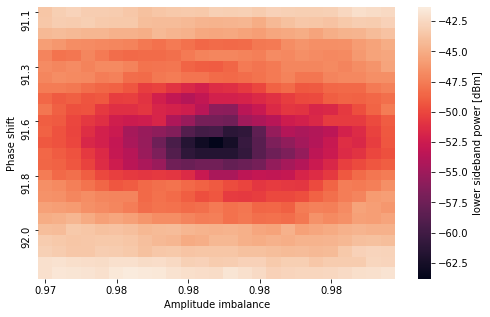

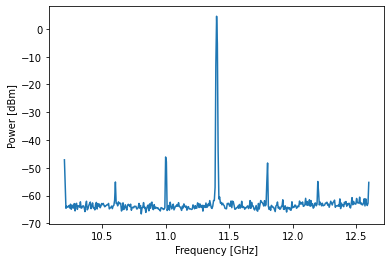

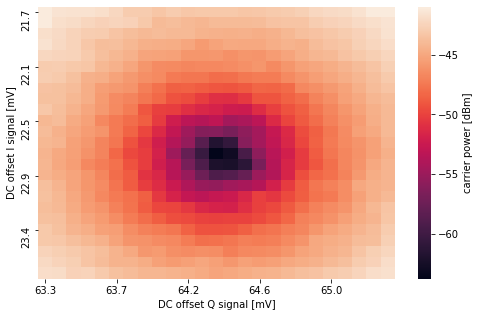

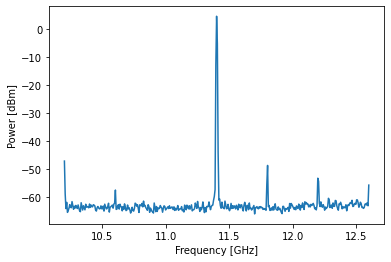

In [32]:
opt1.opt()

In [13]:
opt1.opt_lower_sideband()

KeyboardInterrupt: 

In [6]:
import pylabnet.utils.iq_upconversion.iq_upconversion_misc as ium
ium.get_power_at_harmonics(sa, 12e9, 250e6, [-1, 0, 1, 2, 3])

test


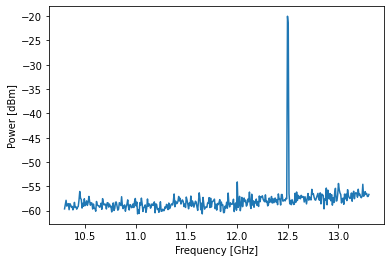

In [10]:
sa.plot_trace()

In [10]:
mw_client.output_on()

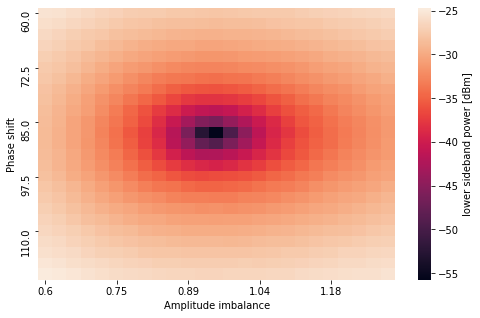

In [21]:
opt1.plot_phase_amp_sweep(60, 120, 0.6, 1.3, 25)

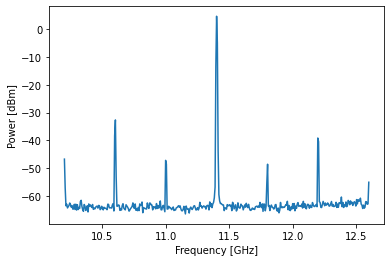

In [31]:
sa.set_reference_level(-5)
sa.plot_trace()

In [ ]:
sa.plo